<br>
# ** 6 Predict the TimeSeries Data**
시계열 데이터 예측

<br><br>
## ** 4 Keras 를 활용한 주가예측**

### **00 주가데이터 가져오기**
> from pandas_datareader import get_data_yahoo

In [1]:
from pandas_datareader import get_data_yahoo
stock = get_data_yahoo('MS', '2016-07-01', '2016-12-31')
stock = stock.fillna('ffill')
stock = stock.dropna()
price = stock.Close
price.tail(3)

Date
2016-12-28    42.619999
2016-12-29    42.150002
2016-12-30    42.250000
Name: Close, dtype: float64

<br>
### ** 01 데이터 전처리**

In [2]:
dataset = stock.reset_index()
dataset.head(2)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2016-06-30,26.0,25.18,25.34,25.98,19736300.0,24.929396
1,2016-07-01,26.4,25.76,25.77,25.92,8863400.0,24.871824


In [3]:
dataset = stock.reset_index()
del dataset['Date']
del dataset['Volume']
del dataset['Adj Close']
dataset.columns = ['Open','High','Low','Close']
dataset.tail(3)

,Open,High,Low,Close
125,43.290001,42.570000,43.250000,42.619999
126,42.770000,41.730000,42.650002,42.150002
127,42.549999,41.880001,42.169998,42.250000


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

Using TensorFlow backend.


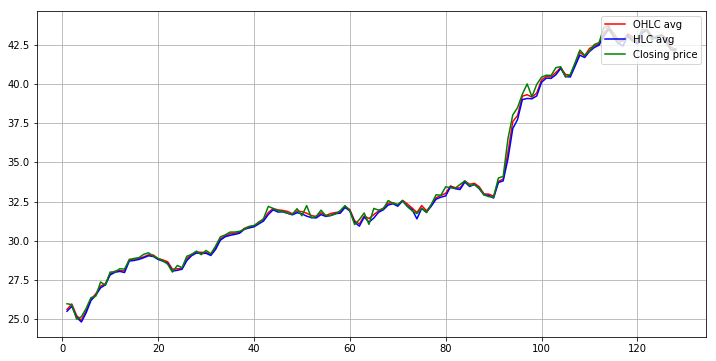

In [5]:
np.random.seed(7)  

obs       = np.arange(1, len(dataset) + 1, 1)
OHLC_avg  = dataset.mean(axis = 1)           
HLC_avg   = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]
plt.figure(figsize=(12,6))
plt.plot(obs, OHLC_avg,  'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg,   'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.grid()
plt.show()

In [6]:
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg), 1) )
print("일평균 데이터 : {},\n {}".format( OHLC_avg[:5], type(OHLC_avg)))

scaler   = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)  
print("정규화 데이터 : {}, {}".format(type(OHLC_avg), OHLC_avg[:5]) )

일평균 데이터 : [[25.625     ]
 [25.9625001 ]
 [25.2249999 ]
 [24.9199996 ]
 [25.53500032]],
 <class 'numpy.ndarray'>
정규화 데이터 : <class 'numpy.ndarray'>, [[0.03769552]
 [0.05574124]
 [0.016308  ]
 [0.        ]
 [0.03288334]]


In [13]:
def new_dataset(dataset, step_size):
    import numpy as np 
    data_X, data_Y = [], []
    for i in range(len(dataset) - step_size - 1):
        data_X.append(dataset[i : (i+step_size), 0])  
        data_Y.append(dataset[i + step_size,     0])
    return np.array(data_X), np.array(data_Y)

train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC  = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY   = new_dataset(test_OHLC, 1)
print(trainX.shape, trainY.shape)  
print(trainX[1], trainY[1])

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX  = np.reshape(testX,  (testX.shape[0],  1, testX.shape[1]))
trainX.shape, testX.shape

(94, 1) (94,)
[25.9625001] 25.22499990463257


((94, 1, 1), (30, 1, 1))

<br>
### ** 02 LSTM 모델 만들기**

In [8]:
step_size = 1
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss='mean_squared_error', optimizer='adam') 
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
 - 4s - loss: 0.0519
Epoch 2/10
 - 1s - loss: 0.0101
Epoch 3/10
 - 1s - loss: 0.0084
Epoch 4/10
 - 1s - loss: 0.0063
Epoch 5/10
 - 1s - loss: 0.0041
Epoch 6/10
 - 1s - loss: 0.0022
Epoch 7/10
 - 1s - loss: 0.0011
Epoch 8/10
 - 1s - loss: 6.4832e-04
Epoch 9/10
 - 1s - loss: 5.1659e-04
Epoch 10/10
 - 1s - loss: 5.5811e-04


In [9]:
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY       = scaler.inverse_transform([trainY])
testPredict  = scaler.inverse_transform(testPredict)
testY        = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore  = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Train RMSE: {:.2f}\nTest  RMSE: {:.2f}'.format(trainScore, testScore))

Train RMSE: 0.41
Test  RMSE: 3.01


<br>
### ** 03 완성된 LSTM 모델의 예측결과 시각화**

In [10]:
trainPredictPlot          = np.empty_like(OHLC_avg)
trainPredictPlot[ : , : ] = np.nan
trainPredictPlot[step_size : len(trainPredict) + step_size , : ] = trainPredict

testPredictPlot       = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (step_size*2) + 1 : len(OHLC_avg) - 1 , : ] = testPredict

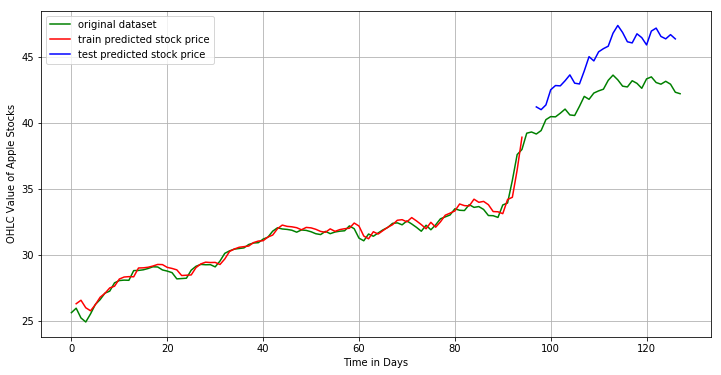

In [11]:
OHLC_avg = scaler.inverse_transform(OHLC_avg)

plt.figure(figsize=(12,6))
plt.plot(OHLC_avg,         'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'train predicted stock price')
plt.plot(testPredictPlot,  'b', label = 'test predicted stock price')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.legend(loc = 'upper left')
plt.grid(); plt.show()

<br>
### ** 04 완성된 LSTM 모델로 내일의 주가 예측**

In [12]:
last_val        = testPredict[-1:]
last_val_scaled = last_val / last_val
next_val        = model.predict(np.reshape(last_val_scaled, (1,1,1)))
last_price      = np.asscalar(last_val)
next_price      = np.asscalar(last_val * next_val)
print ("마지막 예측가격 : {} \n다음날 예측가격 : {} \n증감률 : {}".format(
        last_price, 
        next_price, 
        (next_price - last_val) / last_val) )

마지막 예측가격 : 46.364654541015625 
다음날 예측가격 : 55.686851501464844 
증감률 : [[0.20106257]]
